#Sales Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [3]:
df = pd.read_csv('/content/drive/MyDrive/PED&EBA/Cases/SalesForecastig/sales_historical.csv')
df.head()

,customer_id,date,sales,status
0,f421d071,2022-01-04,1194.0,OK
1,5b3be695,2022-01-05,1794.0,OK
2,21a0678a,2022-01-06,1134.0,OK
3,1237bee4,2022-01-06,1134.0,OK
4,5a08b9ab,2022-01-06,1794.0,OK


In [4]:
# menor data do df
df['date'].min()


'2020-02-28'

In [5]:
df['date'].max()

'2024-06-26'

In [6]:
df.describe()

,sales
count,5856.000000
mean,1625.830251
std,316.532026
min,594.000000
25%,1434.000000
50%,1794.000000
75%,1794.000000
max,3588.000000


In [7]:
df.isnull().sum()

customer_id    0
date           0
sales          0
status         0
dtype: int64

In [8]:
df.duplicated().sum()

0

- Não há dados nulos e nem duplicados no nosso conjunto de dados.

- Como nosso objetivo é prever a qauntidade de vendas OK's nas próximas 3 semanas e depois em 4 meses, vamos filtrar as vendas OK's e agrupa-las por dia.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  5856 non-null   object 
 1   date         5856 non-null   object 
 2   sales        5856 non-null   float64
 3   status       5856 non-null   object 
dtypes: float64(1), object(3)
memory usage: 183.1+ KB


- Primeiramente vamos transformar a coluna date em datetime.

In [10]:
# convertendo data em datetime

df['date'] = pd.to_datetime(df['date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  5856 non-null   object        
 1   date         5856 non-null   datetime64[ns]
 2   sales        5856 non-null   float64       
 3   status       5856 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 183.1+ KB


In [12]:
# Filtrando apenas vendas com status "OK"
df_ok = df[df['status'] == 'OK']

# Agrupando as vendas por dia
df_daily_sales_ok = df_ok.groupby('date').agg({'status': 'count'}).reset_index()

In [13]:
# Definindo a coluna 'date' como índice
df_ok.set_index('date', inplace=True)

In [14]:
df_daily_sales_ok.head()

,date,status
0,2020-02-28,1
1,2021-12-01,1
2,2022-01-04,4
3,2022-01-05,3
4,2022-01-06,4


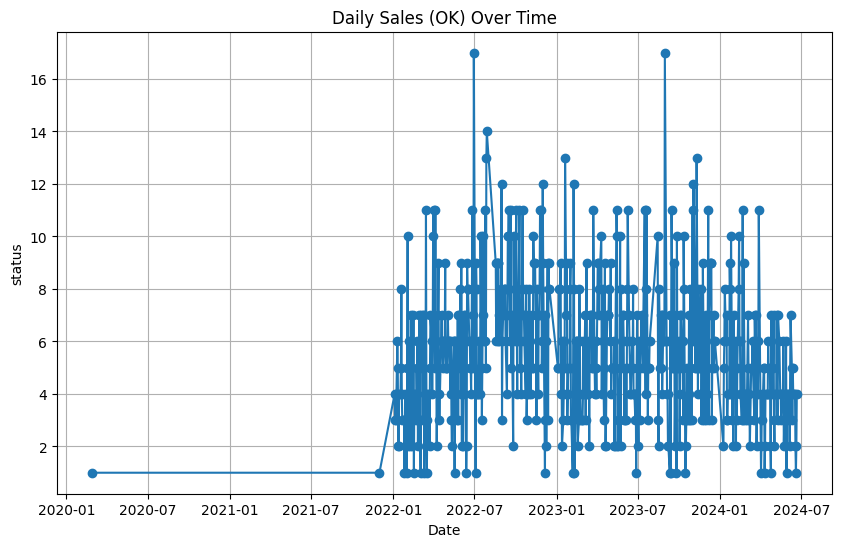

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_daily_sales_ok['date'], df_daily_sales_ok['status'], marker='o')
plt.title('Daily Sales (OK) Over Time')
plt.xlabel('Date')
plt.ylabel('status')
plt.grid(True)
plt.show()

- Vamos verificar como a série das vendas agrupando por semana.

In [16]:

# Agrupando as vendas por semana
df_weekly_sales_ok = df_ok['status'].resample('W').count().reset_index()
df_weekly_sales_ok

,date,status
0,2020-03-01,1
1,2020-03-08,0
2,2020-03-15,0
3,2020-03-22,0
4,2020-03-29,0
...,...,...
221,2024-05-26,19
222,2024-06-02,18
223,2024-06-09,16
224,2024-06-16,21


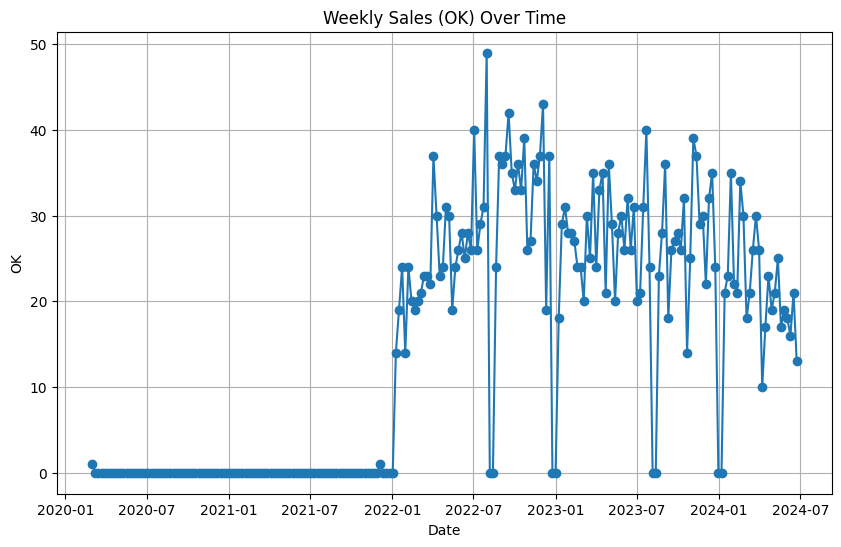

In [17]:
# plotando o gráfico dos dados agregados semanalmente
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sales_ok['date'], df_weekly_sales_ok['status'], marker='o')
plt.title('Weekly Sales (OK) Over Time')
plt.xlabel('Date')
plt.ylabel('OK')
plt.grid(True)
plt.show()

In [18]:
df_weekly_sales_ok

,date,status
0,2020-03-01,1
1,2020-03-08,0
2,2020-03-15,0
3,2020-03-22,0
4,2020-03-29,0
...,...,...
221,2024-05-26,19
222,2024-06-02,18
223,2024-06-09,16
224,2024-06-16,21


Vemos pelo gráfico praticamente uma linha constante nas semanas iniciais. Isto pode ter sido causados por eventos tais como o COVID que impactaram no número de vendas semanais. Portanto vamos fazer as análises a partir de janeiro de 2022.

In [19]:
# filtrar o df_weekly_sales_ok a partir da primeira semana de 2022
df_weekly_sales_ok = df_weekly_sales_ok[df_weekly_sales_ok['date'] >= '2022-01-01']

In [20]:
df_weekly_sales_ok

,date,status
96,2022-01-02,0
97,2022-01-09,14
98,2022-01-16,19
99,2022-01-23,24
100,2022-01-30,14
...,...,...
221,2024-05-26,19
222,2024-06-02,18
223,2024-06-09,16
224,2024-06-16,21


Text(0.5, 1.0, 'Weekly Sales (OK) Over Time')

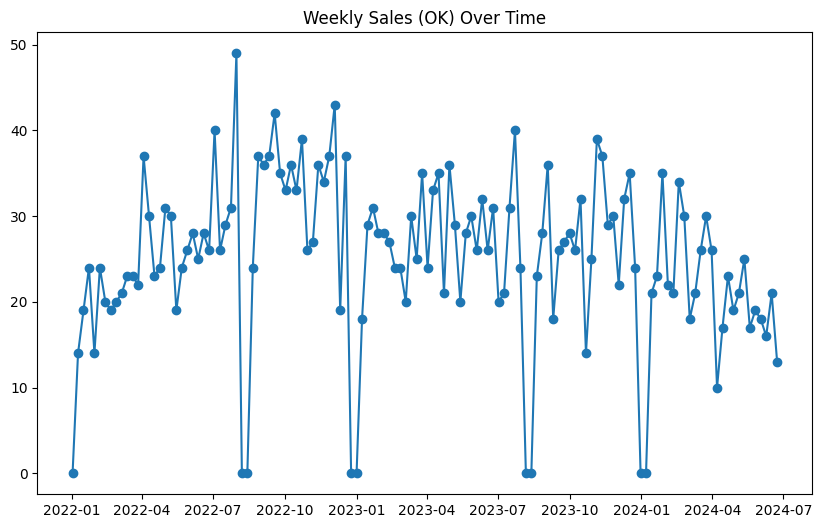

In [21]:
# plotar gráfico df_weekly_sales_ok
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sales_ok['date'], df_weekly_sales_ok['status'], marker='o')
plt.title('Weekly Sales (OK) Over Time')

Vamos avaliar na decomposição dos componentes, para tal, precisamos que a data esteja indexada na mesma frequência que definimos. No nosso caso, semanalmente.

In [22]:
df_weekly_sales_ok.index

Index([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       ...
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225],
      dtype='int64', length=130)

In [23]:
# Definindo a coluna 'date' como índice
df_weekly_sales_ok.set_index('date', inplace=True)

In [24]:
df_weekly_sales_ok.index

DatetimeIndex(['2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23',
               '2022-01-30', '2022-02-06', '2022-02-13', '2022-02-20',
               '2022-02-27', '2022-03-06',
               ...
               '2024-04-21', '2024-04-28', '2024-05-05', '2024-05-12',
               '2024-05-19', '2024-05-26', '2024-06-02', '2024-06-09',
               '2024-06-16', '2024-06-23'],
              dtype='datetime64[ns]', name='date', length=130, freq=None)

In [25]:
# definindo frequencia como semanal
df_weekly_sales_ok = df_weekly_sales_ok.asfreq("W")

In [26]:
df_weekly_sales_ok.index

DatetimeIndex(['2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23',
               '2022-01-30', '2022-02-06', '2022-02-13', '2022-02-20',
               '2022-02-27', '2022-03-06',
               ...
               '2024-04-21', '2024-04-28', '2024-05-05', '2024-05-12',
               '2024-05-19', '2024-05-26', '2024-06-02', '2024-06-09',
               '2024-06-16', '2024-06-23'],
              dtype='datetime64[ns]', name='date', length=130, freq='W-SUN')

In [27]:
df_weekly_sales_ok

,status
date,
2022-01-02,0
2022-01-09,14
2022-01-16,19
2022-01-23,24
2022-01-30,14
...,...
2024-05-26,19
2024-06-02,18
2024-06-09,16


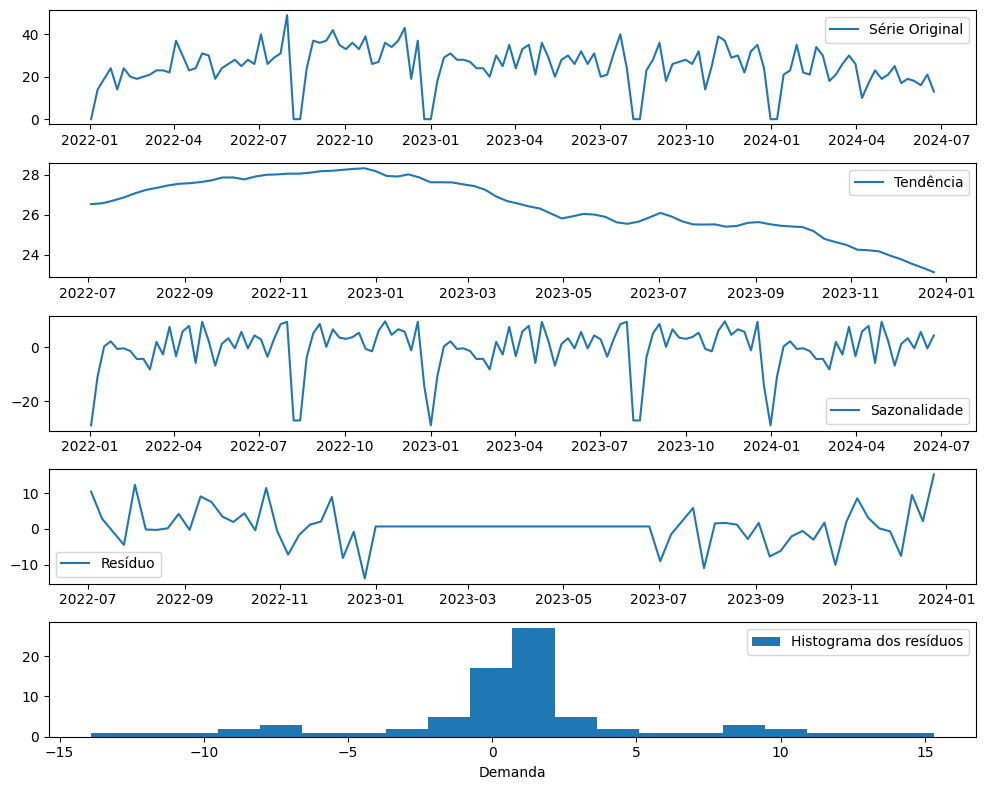

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = df_weekly_sales_ok["status"]

# Realizar a decomposição da série temporal
result = seasonal_decompose(data, model='additive', period=None)

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))
plt.subplot(511)
plt.plot(data, label='Série Original')
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()
plt.xlabel('Demanda')


plt.tight_layout()
plt.show()

Vamos fazer os testes de Ad-Fuller e KPSS para testar se a série é estacionária ou não. Lembrando que o Teste AD-Fuller verifica a presença de raiz unitária na série temporal. Uma série temporal é considerada **ter uma raiz unitária se ela não for estacionária**, ou seja, se sua média e variância não forem constantes ao longo do tempo. Essa verificação acontece comparando a série temporal original com uma versão diferenciada da mesma.

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| ADF | Não é estacionária | É estacionária |

</center>

Já o teste KPSS compara a série temporal com um modelo estacionário que tem características semelhantes à série. Ele avalia a diferença entre a série real e o modelo estacionário para determinar se a série é estacionária ou não.

No KPSS o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| KPSS | É estacionária | Não é estacionária |

</center>

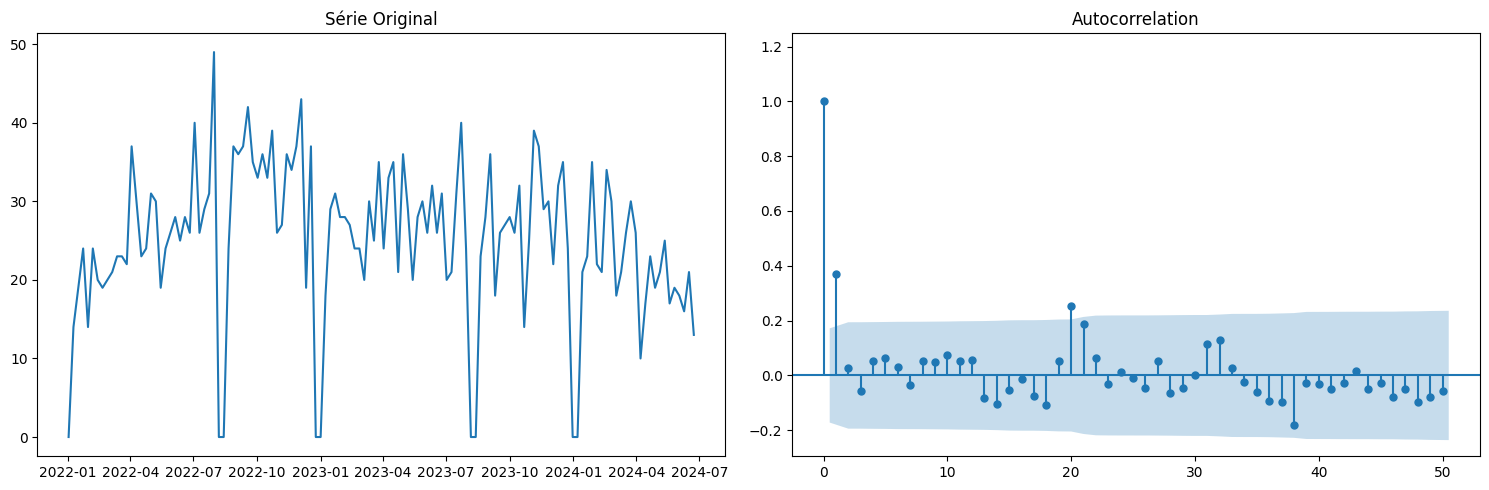

In [29]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Série Original")
ax1.plot(data.dropna())

ax2 = fig.add_subplot(122)
plot_acf(data.dropna(), auto_ylims=True, ax=ax2, lags=50)

plt.tight_layout()
plt.show()

Observando o gráfico de Autocorrelação, verificamos uma queda abruptar após o primeiro lag. Isto indica uma estacionariedade. Vamos prosseguir com o teste de Ad-Fuller e KPSS para confirmar as suposições.

In [30]:
# verificação da estacionariedade da série

from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1])

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mEstacionária com nível de confiança de 95%\u001b[0m")
        else:
            print("\x1b[31mNão estacionária com nível de confiança de 95%\x1b[0m")
        print("\n")

check_stationarity(data.dropna())

Adfuller
p-value: 0.000
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




<ipython-input-30-2c04c55231ff>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = test(series.values)


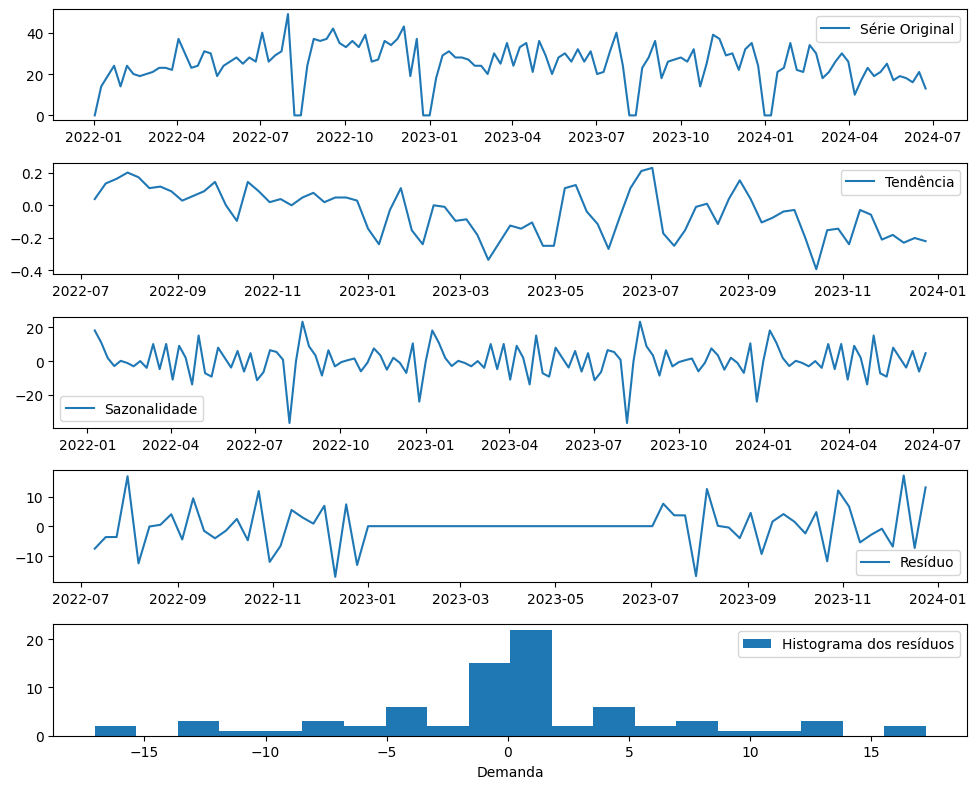

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose



# Realizar a decomposição da série temporal
result = seasonal_decompose(df_weekly_sales_ok["status"].diff().dropna(), model='additive', period=None)

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))
plt.subplot(511)
plt.plot(data, label='Série Original')
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()
plt.xlabel('Demanda')


plt.tight_layout()
plt.show()

In [32]:
# verificação da estacionariedade da série

from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1])

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mStationary with 95% confidence level\u001b[0m")
        else:
            print("\x1b[31mNon-stationary with 95% confidence level\x1b[0m")
        print("\n")

check_stationarity(df_weekly_sales_ok["status"].diff().dropna())

Adfuller
p-value: 0.000
Stationary with 95% confidence level


KPSS
p-value: 0.100
Stationary with 95% confidence level




<ipython-input-32-922571929bac>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = test(series.values)


Apesar da série original já ter passado nos testes de estacionariedade, optei por fazer a primeira diferenciação para ver se conseguiamos estabilizar a tendencia que encontramos na série original.

Vamos prosseguir com ambos o modelo ARIMA(p, 1, q)

### 2º diferenciação

Vamos testar o modelo fazendo 2 diferenciações para verificar o comportamento da tendência.

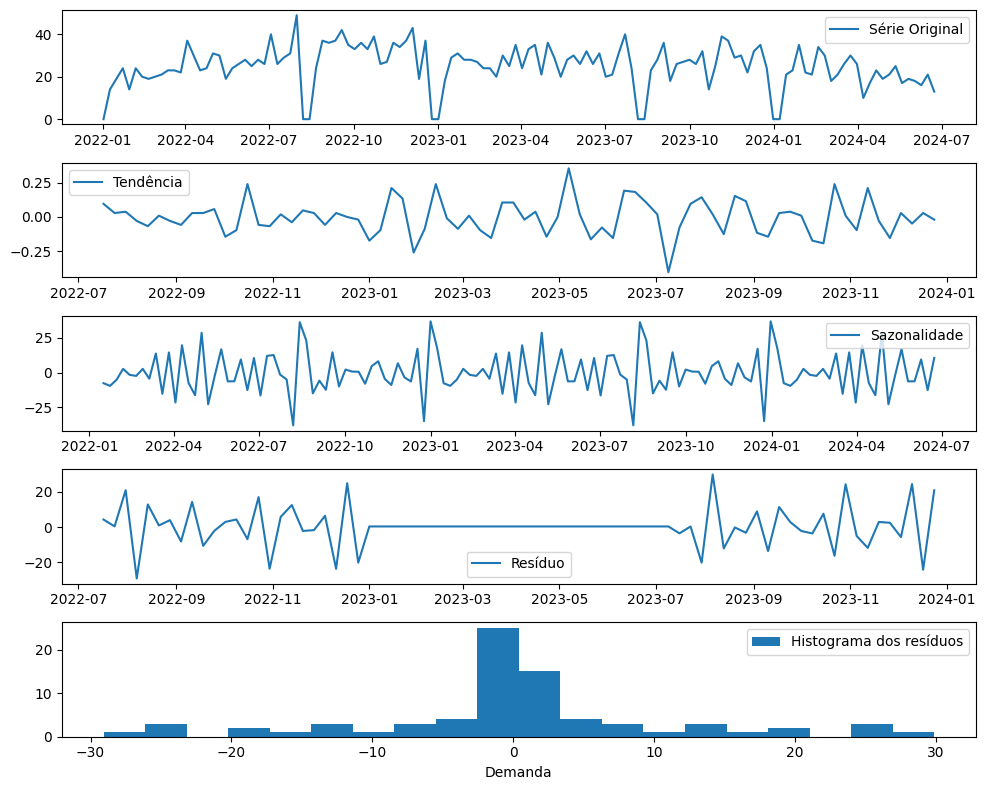

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose



# Realizar a decomposição da série temporal
result_1 = seasonal_decompose(df_weekly_sales_ok["status"].diff().diff().dropna(), model='additive', period=None)

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))
plt.subplot(511)
plt.plot(data, label='Série Original')
plt.legend()

plt.subplot(512)
plt.plot(result_1.trend, label='Tendência')
plt.legend()

plt.subplot(513)
plt.plot(result_1.seasonal, label='Sazonalidade')
plt.legend()

plt.subplot(514)
plt.plot(result_1.resid, label='Resíduo')
plt.legend()

plt.subplot(515)
plt.hist(result_1.resid, bins=20, label="Histograma dos resíduos")
plt.legend()
plt.xlabel('Demanda')


plt.tight_layout()
plt.show()

In [46]:
# verificação da estacionariedade da série

from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1])

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mStationary with 95% confidence level\u001b[0m")
        else:
            print("\x1b[31mNon-stationary with 95% confidence level\x1b[0m")
        print("\n")

check_stationarity(df_weekly_sales_ok["status"].diff().diff().dropna())

Adfuller
p-value: 0.000
Stationary with 95% confidence level


KPSS
p-value: 0.100
Stationary with 95% confidence level




<ipython-input-46-965498d36566>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = test(series.values)


A seguir vamos fazer um modelo com o parâmetro d=1 e outro com o parâmetro d=2 para verificar qual deles é a melhor opção.

## MODELO COM d=1

### Determinando o valor de MA(q)

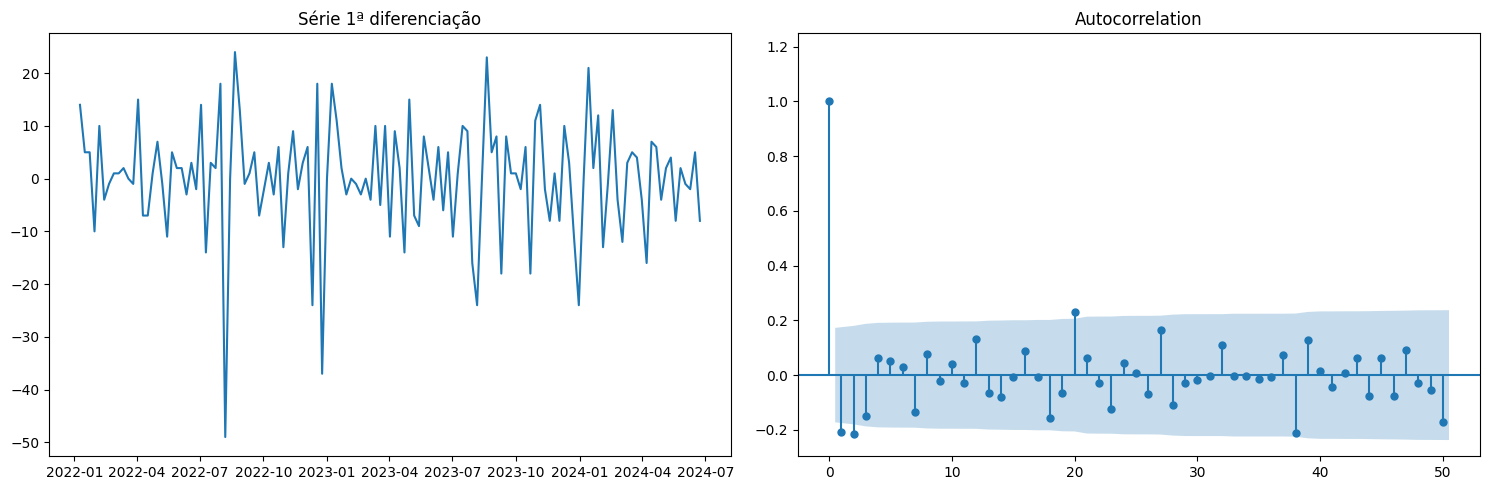

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Série 1ª diferenciação")
ax1.plot(df_weekly_sales_ok["status"].diff().dropna())

ax2 = fig.add_subplot(122)
plot_acf(df_weekly_sales_ok["status"].diff().dropna(), auto_ylims=True, ax=ax2, lags=50)

plt.tight_layout()
plt.show()

Do gráfico acima, podemos perceber uma queda após o lag 2. Logo nosso q = 2 e temos um modelo **ARIMA(0, 1, 2)**


### Determinando o valor de AR(p)

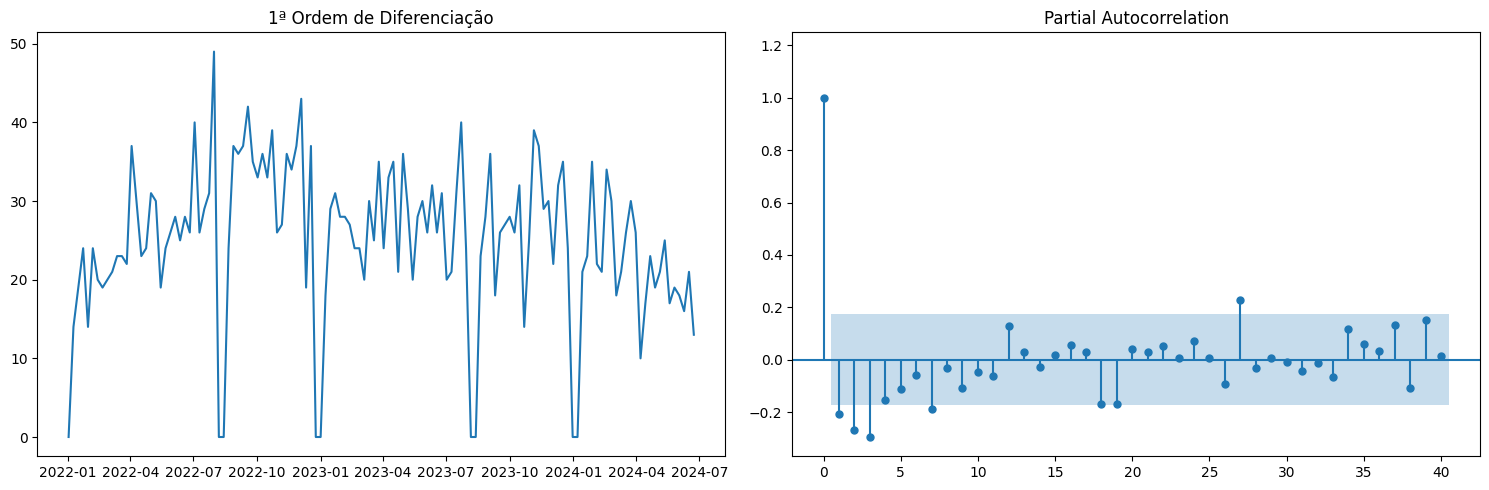

In [51]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("1ª Ordem de Diferenciação")
ax1.plot(df_weekly_sales_ok["status"])

ax2 = fig.add_subplot(122)
plot_pacf(df_weekly_sales_ok["status"].diff().dropna(), auto_ylims=True, ax=ax2, lags=40)
plt.tight_layout()
plt.show()

Com base no gráfico de autocorrelação parcial, vemos uma queda abrupta após o lag 3, logo o p= 3 e nosso modelo será o ARIMA(3,1,0).

Segundo a tabela desenvolvida por Box e Jenkins, para o caso da nossa série deveríamos escolher o  modelo entre o $MA(2)$ e o $AR(3)$, uma vez que nosso PACF tem uma queda gradual, enquanto o ACF uma queda abrupta.

| ACF                                  | PACF                                | Modelo a ser tentado                             |
|--------------------------------------|-------------------------------------|---------------------------------------------------|
| Queda gradual ou sinusoidal até zero| Queda abrupta após lag p           | AR(p)                                             |
| Queda abrupta após lag q            | Queda gradual ou sinusoidal até zero| MA(q)                                             |
| Queda abrupta após lag q            | Queda abrupta após lag p           | Escolha o melhor entre AR(p) e MA(q)             |
| Queda gradual ou sinusoidal até zero| Queda gradual ou sinusoidal até zero| Modelo ARMA                                      |
| Sem picos expressivos               | Sem picos expressivos              | Série é randômica ou ruído branco                |
| Picos em intervalos fixos           | Picos em intervalos fixos          | A série possui sazonalidade                      |
| Não decai até zero ou demora muitos lags | -                                | Série não é estacionária                         |




## Fit do Modelo

Vamos começar criando o modelo $AR(0, 1, 2)$ com o método `ARIMA` da biblioteca `statsmodel`:

In [53]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_weekly_sales_ok["status"], order=(0, 1, 2))
ma_model = model.fit()
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 status   No. Observations:                  130
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -467.874
Date:                Mon, 22 Jul 2024   AIC                            941.748
Time:                        11:37:22   BIC                            950.327
Sample:                    01-02-2022   HQIC                           945.234
                         - 06-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5665      0.058     -9.806      0.000      -0.680      -0.453
ma.L2         -0.3500      0.066     -5.274      0.000      -0.480      -0.220
sigma2        81.6888      8.398      9.727      0.0

A equação de um modelo $MA(2)$ é do tipo:

$ŷ_t = \theta_1 \epsilon_1 +  \theta_2 \epsilon_2 +  cte$

Como todos os p-valores do parâmetro $\theta$ deram menores do que 0.056, temos a equação a seguir:

$ŷ_t = -0.56 \epsilon_1 -0.35 \epsilon_2+  81.68$

A nível de comparação, vamos testar também como seria nosso modelo no caso **ARIMA (3,1,0)**.

In [54]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_weekly_sales_ok["status"], order=(3, 1, 0))
ar_model = model.fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 status   No. Observations:                  130
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -474.423
Date:                Mon, 22 Jul 2024   AIC                            956.846
Time:                        11:37:38   BIC                            968.285
Sample:                    01-02-2022   HQIC                           961.494
                         - 06-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3564      0.070     -5.096      0.000      -0.493      -0.219
ar.L2         -0.3578      0.065     -5.465      0.000      -0.486      -0.229
ar.L3         -0.3050      0.100     -3.061      0.0

A equação de um modelo $AR(3)$ é do tipo:

$ŷ_t = \phi_1 y_1 + \phi_2 y_2 + \phi_3 y_3 + cte$

Assim, a nossa equação AR(1) fica:

$ŷ_t = - 0.3564 y_1 - 0.3578 y_2 - 0.3050 y_3 + 91.2578$

Vamos verificar pelo pmdarima quais parâmetros ele encontra para determinar o melhor modelo.

In [38]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00


In [47]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np

# Dividir os dados em conjunto de treinamento e teste
train, test = train_test_split(df_weekly_sales_ok["status"], train_size=0.8)

# Encontrar os melhores parâmetros do modelo ARIMA usando auto_arima
modelo_auto = pm.auto_arima(
    train, # série de dados
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    d=1,
    max_order=None, # ordem máxima total do modelo ARIMA
    seasonal=False, # permitir que o modelo ajuste componentes sazonais
    stepwise=True, # utiliza uma abordagem heurística de seleção de modelo, se False, usa uma busca completa.
    trace=True, # True, exibe informações detalhadas sobre o processo de seleção do modelo
    error_action='ignore', # Ação a ser tomada se ocorrerem erros durante o processo de seleção do modelo. Pode ser 'warn', 'raise' ou 'ignore'
    suppress_warnings=True) # suprime todos os avisos

# Ajustar o melhor modelo ARIMA encontrado
pmdarima = pm.ARIMA(order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
pmdarima.fit(train)

# Fazer previsões
predicao = pmdarima.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=789.965, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=785.303, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=767.825, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=788.011, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=766.446, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=758.231, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 4.223 seconds


Pelo modelo auto arima, temos indicação que os melhores parametros são so **ARIMA (0,1,2)**.

In [55]:
print(f"AR(1)/ARIMA(3, 1, 0) - AIC: {ar_model.aic:.1f} BIC: {ar_model.bic:.1f}")
print(f"MA(2)/ARIMA(0, 1, 2) - AIC: {ma_model.aic:.1f} BIC: {ma_model.bic:.1f}")

AR(1)/ARIMA(3, 1, 0) - AIC: 956.8 BIC: 968.3
MA(2)/ARIMA(0, 1, 2) - AIC: 941.7 BIC: 950.3


Comparando os valores de AIC e BIC, confirmamos que os menores valores são obtidos quando seguimos com o modelo $MA(2)$.

## MODELO d=2

### Determinando o valor de MA(q)

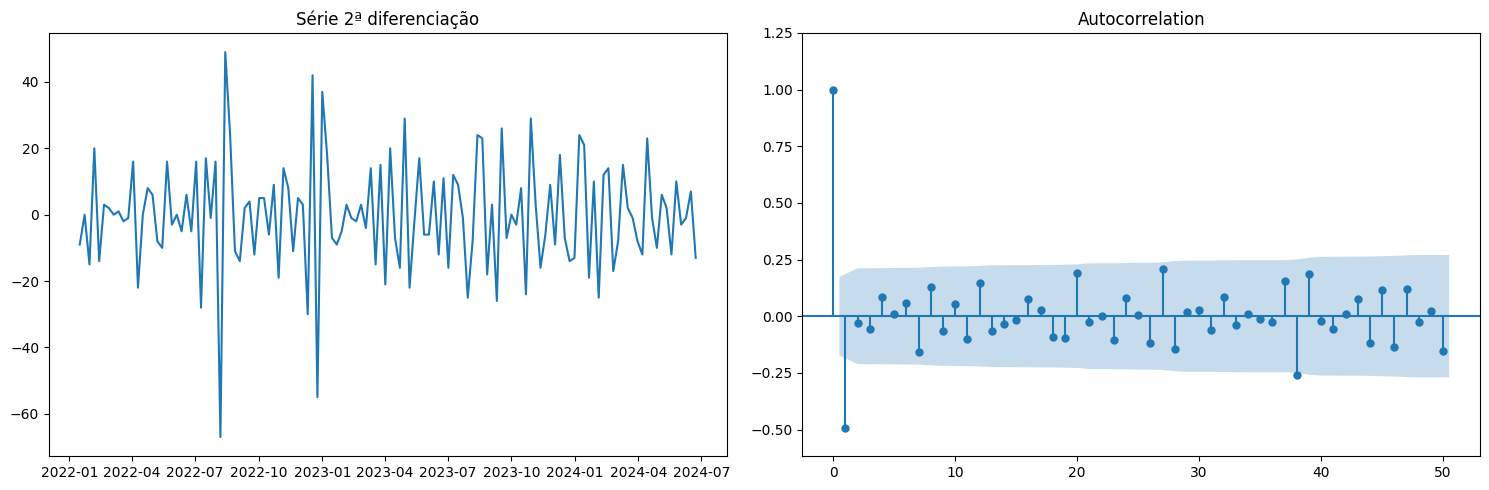

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Série 2ª diferenciação")
ax1.plot(df_weekly_sales_ok["status"].diff().diff().dropna())

ax2 = fig.add_subplot(122)
plot_acf(df_weekly_sales_ok["status"].diff().diff().dropna(), auto_ylims=True, ax=ax2, lags=50)

plt.tight_layout()
plt.show()

Com base no gráfico de autocorrelação acima, vemos uma queda abrupta após o lag 1. Logo nosso parâmetro q =1 e o modelo a ser testado é o **ARIMA(0,2,1)**.

### Determinando o valor de AR(p)

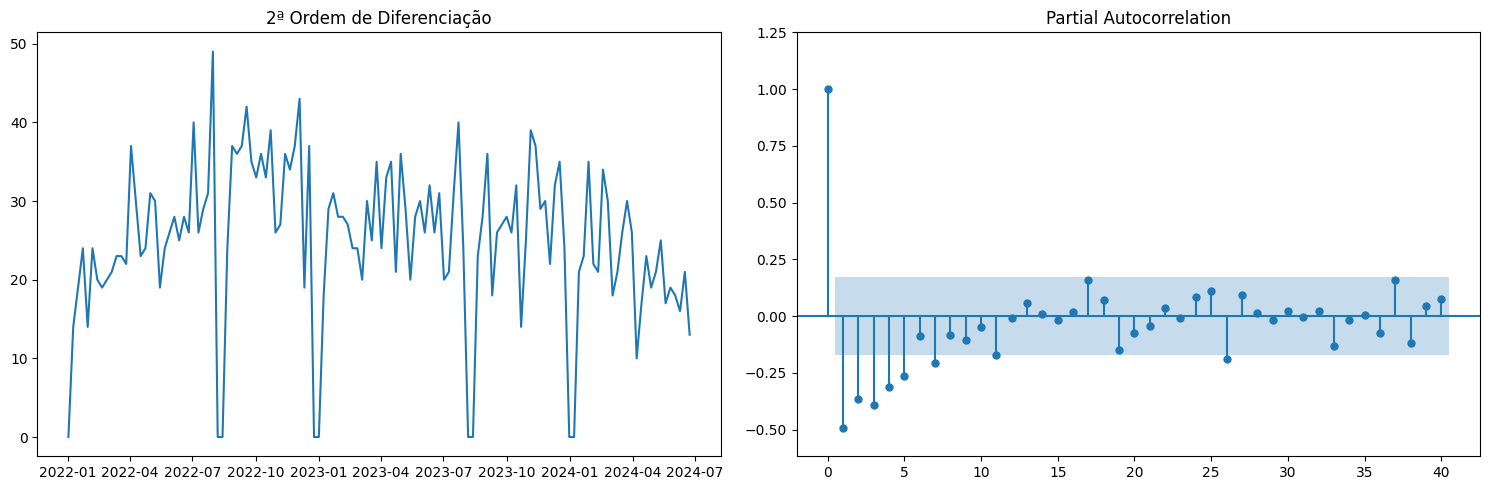

In [56]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("2ª Ordem de Diferenciação")
ax1.plot(df_weekly_sales_ok["status"])

ax2 = fig.add_subplot(122)
plot_pacf(df_weekly_sales_ok["status"].diff().diff().dropna(), auto_ylims=True, ax=ax2, lags=40)
plt.tight_layout()
plt.show()

Observando o gráfico acima, temos uma queda gradual para o zero, vamos escolher o modelo MA(1), de acordo com a tabela abaixo:

| ACF                                  | PACF                                | Modelo a ser tentado                             |
|--------------------------------------|-------------------------------------|---------------------------------------------------|
| Queda gradual ou sinusoidal até zero| Queda abrupta após lag p           | AR(p)                                             |
| Queda abrupta após lag q            | Queda gradual ou sinusoidal até zero| MA(q)                                             |
| Queda abrupta após lag q            | Queda abrupta após lag p           | Escolha o melhor entre AR(p) e MA(q)             |
| Queda gradual ou sinusoidal até zero| Queda gradual ou sinusoidal até zero| Modelo ARMA                                      |
| Sem picos expressivos               | Sem picos expressivos              | Série é randômica ou ruído branco                |
| Picos em intervalos fixos           | Picos em intervalos fixos          | A série possui sazonalidade                      |
| Não decai até zero ou demora muitos lags | -                                | Série não é estacionária                         |

### Fit do Modelo ARIMA(0,2,1)

In [62]:
from statsmodels.tsa.arima.model import ARIMA

model_3 = ARIMA(df_weekly_sales_ok["status"], order=(0, 2, 1))
ma_model_3 = model_3.fit()
print(ma_model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                 status   No. Observations:                  130
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -487.642
Date:                Mon, 22 Jul 2024   AIC                            979.283
Time:                        11:57:54   BIC                            984.987
Sample:                    01-02-2022   HQIC                           981.601
                         - 06-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      1.504     -0.664      0.507      -3.948       1.949
sigma2       114.9127    170.506      0.674      0.500    -219.272     449.098
Ljung-Box (L1) (Q):                   5.60   Jarque-

Como obtivemos o BIC e AIC mais alto que os anteriores, não vamos seguir com este modelo.

# Forecasting: Modelo ARIMA (0,1,2)

Como nosso objetivo é fazer a previsão dos próximos 4 meses, precisamos definir quantos pontos queremos prever, como a frenquência dos dados é semanal, queremos na verdade prever 16 pontos (4 semanas por mÊs).

In [63]:
df_weekly_sales_ok["status"].index[0]

Timestamp('2022-01-02 00:00:00')

In [64]:
df_weekly_sales_ok["status"].index[-1] + pd.DateOffset(weeks=16)

Timestamp('2024-10-13 00:00:00')

In [81]:
n=16 # quantidade de pontos que quero no forecast

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_weekly_sales_ok["status"], order=(0, 1, 2))
ma_model = model.fit()

# Previsão do modelo para todos os pontos do nosso dataset
pred = ma_model.get_prediction(start=df_weekly_sales_ok.index[0], end=df_weekly_sales_ok.index[-1] + pd.DateOffset(weeks=16))

In [82]:
pred

In [83]:
# DataFrame contendo os resultados da previsão e os intervalos de confiança.
pred.summary_frame()

status,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-01-02,0.000000,1000.058952,-1960.079529,1960.079529
2022-01-09,0.000000,10.858512,-21.282293,21.282293
2022-01-16,10.428322,10.499202,-10.149736,31.006379
2022-01-23,12.699239,9.914888,-6.733584,32.132063
2022-01-30,17.204807,9.716076,-1.838351,36.247966
...,...,...,...,...
2024-09-15,21.132645,10.136225,1.266009,40.999282
2024-09-22,21.132645,10.164311,1.210962,41.054328
2024-09-29,21.132645,10.192319,1.156068,41.109223
2024-10-06,21.132645,10.220250,1.101324,41.163967


In [84]:
print(pred.prediction_results.npredictions)
print(pred.prediction_results.nforecast)

-146
16


In [85]:
pred.predicted_mean

2022-01-02     0.000000
2022-01-09     0.000000
2022-01-16    10.428322
2022-01-23    12.699239
2022-01-30    17.204807
                ...    
2024-09-15    21.132645
2024-09-22    21.132645
2024-09-29    21.132645
2024-10-06    21.132645
2024-10-13    21.132645
Freq: W-SUN, Name: predicted_mean, Length: 146, dtype: float64

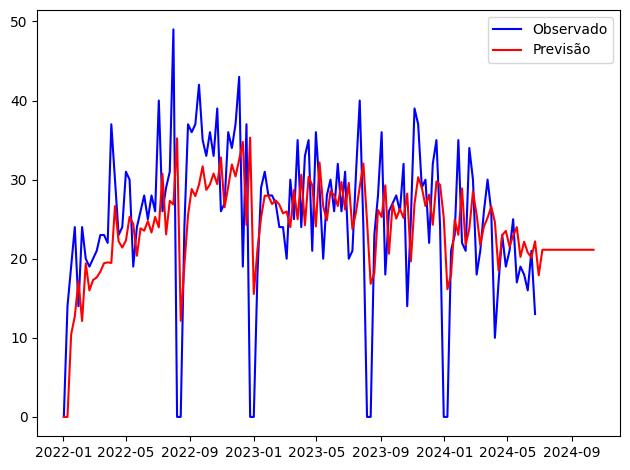

In [86]:
n=16 # quantidade de pontos que quero no forecast

forecast = pred.predicted_mean # predict_mean contém os valores previstos

plt.plot(df_weekly_sales_ok, label='Observado', color='blue')  # Plotar a série temporal original
plt.plot(forecast, label='Previsão', color='red')  # Plotar as previsões
plt.legend()
plt.tight_layout()
plt.show()

Note que o modelo começa as previsões com erros maiores e conforme ele vai recebendo os dados, os valores previstos vão se aproximando. Entretanto, o modelo não capta bem os valores de pico da série, isto pode ser devido a fatores sazonais.

Podemos aqui construir um modelo SARIMA para melhorar o modelo.

### Treina o modelo em um conjunto e valida apenas no fim da série temporal

Vamos considerar que nosso dataset de teste consiste apenas os últimos 16 pontos:

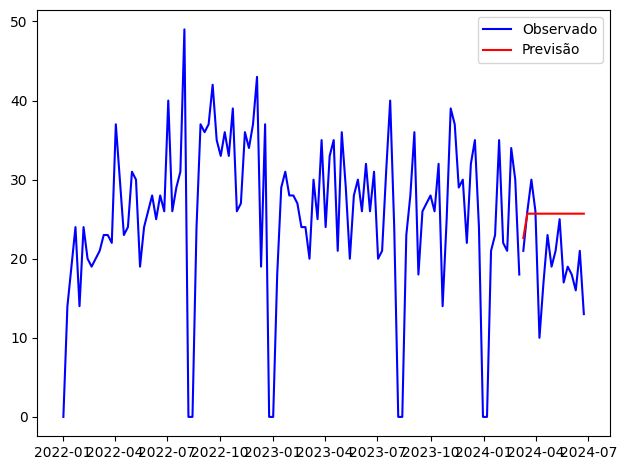

In [87]:
# Definir o número de pontos para previsão
n = 16

# Separo em treino e teste
df_train = df_weekly_sales_ok[:-n].copy()
df_test = df_weekly_sales_ok[-n:].copy()

# Ajustar o modelo ARIMA usando apenas o conjunto de dados de treinamento
model = ARIMA(df_train, order=(0, 1, 2))
ma_model = model.fit()

# Fazer previsões para o conjunto de dados de teste
pred = ma_model.get_prediction(start=df_test.index[0], end=df_test.index[-1])
forecast = pred.predicted_mean  # Valores previstos

# Plotar a série temporal original e as previsões
plt.plot(df_train.index, df_train.values, label='Observado', color='blue')  # Conjunto de treino
plt.plot(df_test.index, df_test.values, color='blue')  # Conjunto de teste
plt.plot(forecast.index, forecast.values, label='Previsão', color='red')  # Previsões
plt.legend()
plt.tight_layout()
plt.show()

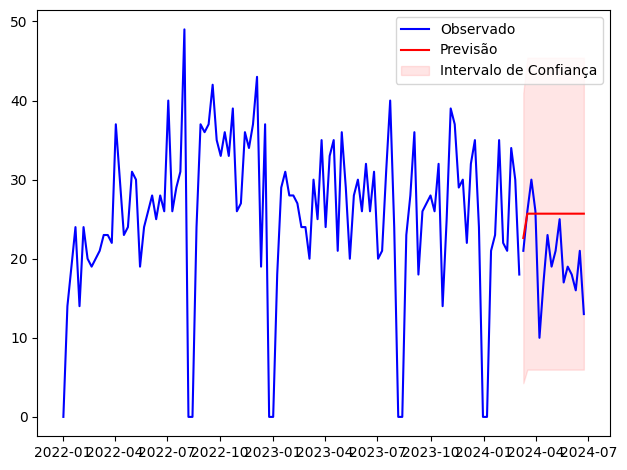

In [88]:
# Obtem os intervalos de confiança
conf_int = pred.conf_int()

plt.plot(df_train.index, df_train.values, label='Observado', color='blue')  # Conjunto de treino
plt.plot(df_test.index, df_test.values, color='blue')  # Conjunto de teste
plt.plot(forecast.index, forecast.values, label='Previsão', color='red')  # Previsões
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Intervalo de Confiança')

plt.legend()
plt.tight_layout()
plt.show()

## Forecasting Modelo ARIMA(3,1,0)

In [77]:
df_weekly_sales_ok["status"].index[0]


Timestamp('2022-01-02 00:00:00')

In [78]:
df_weekly_sales_ok["status"].index[-1] + pd.DateOffset(weeks=16)

Timestamp('2024-10-13 00:00:00')

In [89]:
n=16 # quantidade de pontos que quero no forecast

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_weekly_sales_ok["status"], order=(3, 1, 0))
ar_model = model.fit()

# Previsão do modelo para todos os pontos do nosso dataset
pred = ar_model.get_prediction(start=df_weekly_sales_ok.index[0], end=df_weekly_sales_ok.index[-1] + pd.DateOffset(weeks=16))

In [90]:
# DataFrame contendo os resultados da previsão e os intervalos de confiança.
pred.summary_frame()

status,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-01-02,0.000000,1000.057019,-1960.075741,1960.075741
2022-01-09,0.000000,10.679026,-20.930507,20.930507
2022-01-16,11.005580,10.431896,-9.440559,31.451720
2022-01-23,13.791454,10.030690,-5.868337,33.451244
2022-01-30,16.159475,9.552896,-2.563857,34.882807
...,...,...,...,...
2024-09-15,15.741967,18.508969,-20.534946,52.018881
2024-09-22,15.706874,19.088561,-21.706018,53.119766
2024-09-29,15.675769,19.668984,-22.874730,54.226268
2024-10-06,15.691007,20.238861,-23.976432,55.358446


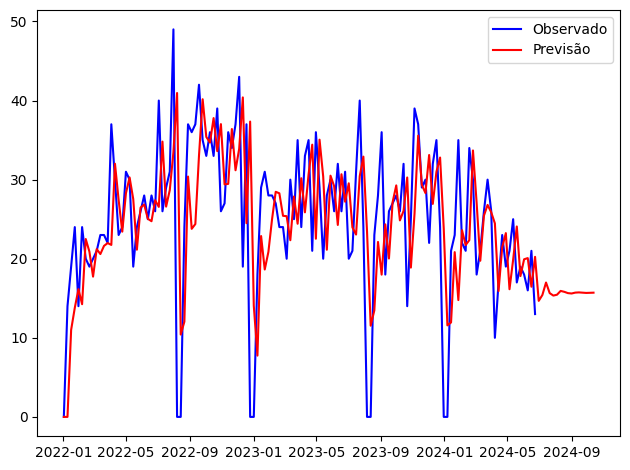

In [91]:
n=16 # quantidade de pontos que quero no forecast

forecast = pred.predicted_mean # predict_mean contém os valores previstos

plt.plot(df_weekly_sales_ok, label='Observado', color='blue')  # Plotar a série temporal original
plt.plot(forecast, label='Previsão', color='red')  # Plotar as previsões
plt.legend()
plt.tight_layout()
plt.show()

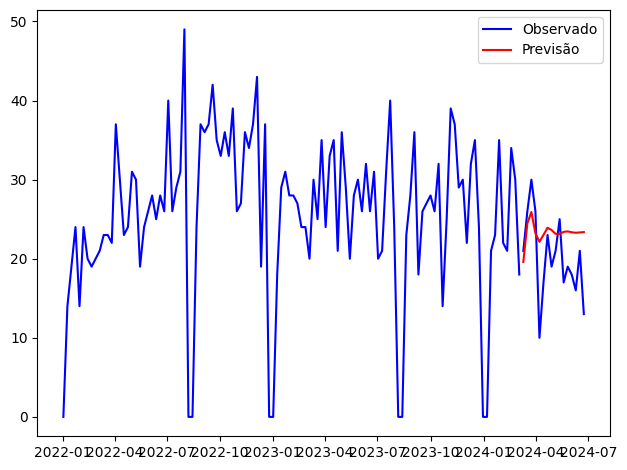

In [92]:
# Definir o número de pontos para previsão
n = 16

# Separo em treino e teste
df_train = df_weekly_sales_ok[:-n].copy()
df_test = df_weekly_sales_ok[-n:].copy()

# Ajustar o modelo ARIMA usando apenas o conjunto de dados de treinamento
model = ARIMA(df_train, order=(3, 1, 0))
ar_model = model.fit()

# Fazer previsões para o conjunto de dados de teste
pred = ar_model.get_prediction(start=df_test.index[0], end=df_test.index[-1])
forecast = pred.predicted_mean  # Valores previstos

# Plotar a série temporal original e as previsões
plt.plot(df_train.index, df_train.values, label='Observado', color='blue')  # Conjunto de treino
plt.plot(df_test.index, df_test.values, color='blue')  # Conjunto de teste
plt.plot(forecast.index, forecast.values, label='Previsão', color='red')  # Previsões
plt.legend()
plt.tight_layout()
plt.show()